In [122]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import igraph as ig
from typing import Callable
import os
from pathlib import Path

# Утилиты

In [123]:
def read_dimacs_graph(file: Path) -> ig.Graph:
    """Read graph from DIMACS format."""
    edges, weights = set(), []
    max_node = 0

    with file.open() as f:
        for line in f:
            if line.startswith("a"):
                _, u, v, w = line.strip().split()
                u, v, w = int(u), int(v), int(w)
                new_edge = (min(u, v) - 1, max(u, v) - 1)

                if new_edge not in edges:
                    edges.add(new_edge)
                    weights.append(w)
                    max_node = max(max_node, u, v)

    G = ig.Graph()
    G.add_vertices(max_node)  # max_node = nodes count
    G.add_edges(edges)
    G.es["weight"] = weights
    return G


def save_dimacs_graph(G: ig.Graph, file: Path, comment: str = ""):
    """save graph with DIMACS format."""
    with file.open("w") as f:
        f.write(f"c {comment}\n")
        f.write(f"p sp {G.vcount()} {G.ecount()}\n")
        for e in G.es:
            u, v = G.es[e.index].tuple
            if "weight" not in e.attributes():
                raise ValueError(f"There is no weights in graph '{file.name}'")
            w = e["weight"]
            f.write(f"a {u + 1} {v + 1} {w}\n")


# --- Test ---

test_graph = read_dimacs_graph(Path("test-graph.gr"))
save_dimacs_graph(test_graph, Path("test-graph-save.gr"))
test_graph = read_dimacs_graph(Path("test-graph-save.gr"))

assert test_graph.vcount() == 5
assert test_graph.ecount() == 7
assert test_graph.es["weight"] == [5, 4, 10, 12, 13, 8, 3]

os.remove("test-graph-save.gr")

In [ ]:
def decrease_density(G: ig.Graph, percent: float, graph_name="test") -> ig.Graph:
    assert 0 < percent < 1

    edges_to_remove_count = int(G.ecount() * percent)

    h_edges = list(G.es)

    bridge_ids = set(G.bridges())
    edges_without_bridges = [
        (e.source, e.target, e["weight"]) for e in h_edges if e.index not in bridge_ids
    ]
    sorted_edges = sorted(edges_without_bridges, key=lambda x: x[2])

    result_graph: ig.Graph = G.copy()

    # {vertex id: vertex degree}
    degrees = {v.index: deg for v, deg in zip(result_graph.vs, result_graph.degree())}

    edges_to_remove_ids = set()
    while len(edges_to_remove_ids) < edges_to_remove_count and sorted_edges:
        u, v, _ = sorted_edges.pop()

        if degrees[u] <= 1 or degrees[v] <= 1:
            continue

        degrees[u] -= 1
        degrees[v] -= 1

        eid = result_graph.get_eid(u, v, directed=False, error=False)
        if eid != -1:
            edges_to_remove_ids.add(eid)

    result_graph.delete_edges(edges_to_remove_ids)

    assert len(result_graph.connected_components(mode="strong")) == 1, (
        "Graph was broken during decreasing."
    )

    print(
        f"--- Decreasing density in '{graph_name}' by {percent * 100:.2f}% ---\n\
        Was: {G.ecount()} edges\n\
        Now: {result_graph.ecount()}, it is {(G.ecount() - result_graph.ecount()) / G.ecount() * 100:.2f}% of the original number.\n\
        Components: {result_graph.connected_components(mode="weak")}"
    )
    return result_graph


# --- Test ---
test_graph = read_dimacs_graph(Path("test-graph.gr"))
decreased_graph = decrease_density(test_graph, percent=0.3)

assert decreased_graph.ecount() == 5
assert decreased_graph.vcount() == 5
assert len(decreased_graph.es["weight"]) == decreased_graph.ecount()
assert decreased_graph.es["weight"] == [5, 4, 10, 8, 3]

--- Decreasing density in 'test' by 30.00% ---
        Was: 7 edges
        Now: 5, it is 28.57% of the original number.
        Components: Clustering with 5 elements and 1 clusters
[0] 0, 1, 2, 3, 4


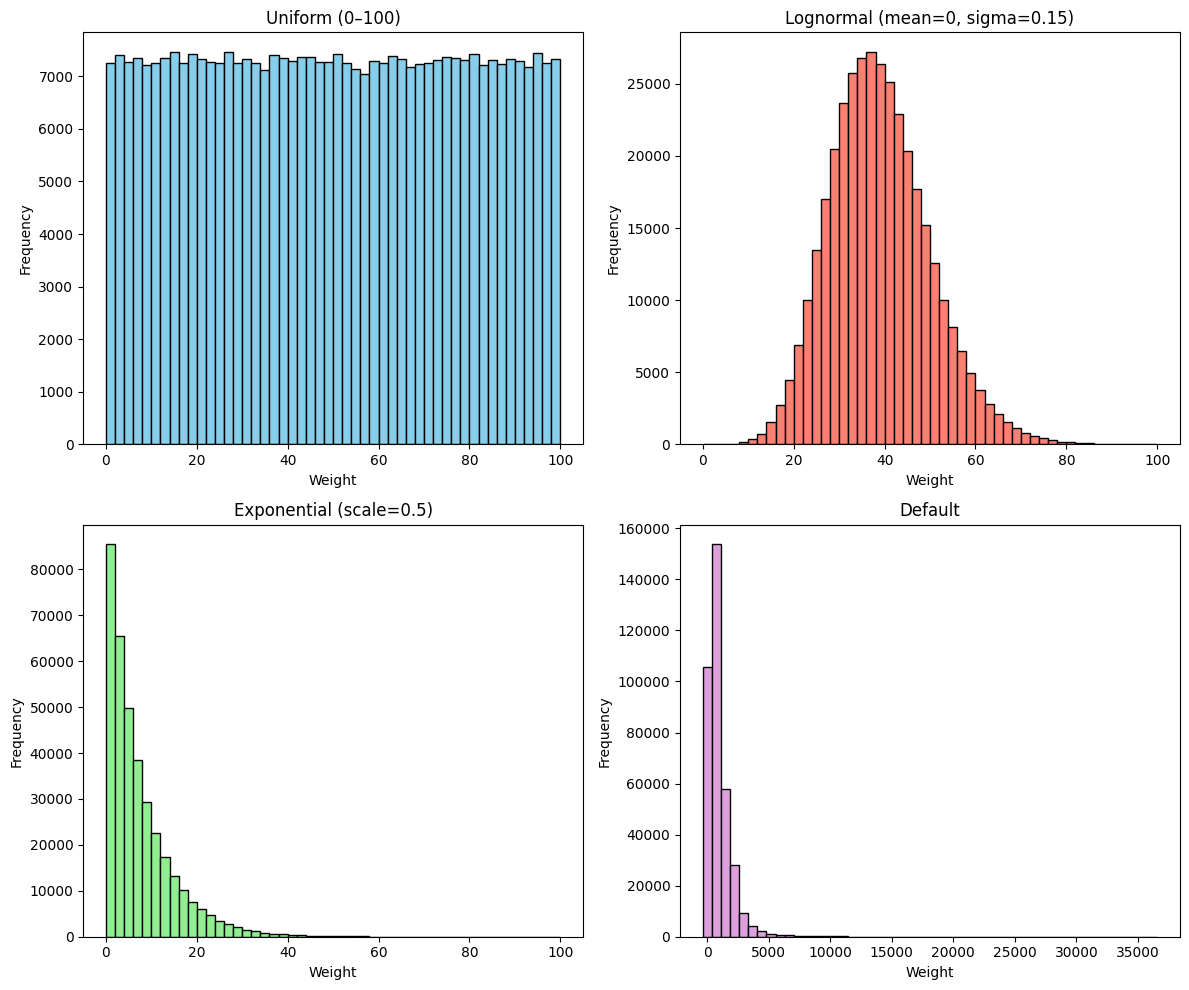

In [ ]:
def scale_weights(weights):
    min_w = np.min(weights)
    max_w = np.max(weights)
    scaled = (weights - min_w) / (max_w - min_w) * 100
    return scaled.astype(int)


def change_weights_distribution(
    G: ig.Graph, f: Callable[[int], np.ndarray]
) -> ig.Graph:
    edges_count = len(G.es)

    result_graph: ig.Graph = G.copy()
    result_graph.es["weight"] = scale_weights(f(edges_count))

    return result_graph


# --- Test ---

test_graph = read_dimacs_graph(Path("../dataset/NY.gr"))
changed_graph = change_weights_distribution(
    test_graph, f=lambda size: np.random.randint(0, 100, size=(size))
)

assert len(changed_graph.es["weight"]) == len(test_graph.es["weight"])
assert changed_graph.vcount() == test_graph.vcount()
assert changed_graph.ecount() == test_graph.ecount()
assert changed_graph.es["weight"] != test_graph.es["weight"]

uniform_weights = change_weights_distribution(
    test_graph, f=lambda size: np.random.randint(0, 100, size=(size))
).es["weight"]

lognorm_weights = change_weights_distribution(
    test_graph, f=lambda size: np.random.lognormal(mean=0, sigma=0.15, size=size)
).es["weight"]

exp_weights = change_weights_distribution(
    test_graph, f=lambda size: np.random.exponential(scale=0.75, size=size)
).es["weight"]

default_weights = test_graph.es["weight"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Uniform
axs[0, 0].hist(uniform_weights, bins=50, color="skyblue", edgecolor="black")
axs[0, 0].set_title("Uniform (0–100)")
# Lognormal
axs[0, 1].hist(lognorm_weights, bins=50, color="salmon", edgecolor="black")
axs[0, 1].set_title("Lognormal (mean=0, sigma=0.15)")
# Exponential
axs[1, 0].hist(exp_weights, bins=50, color="lightgreen", edgecolor="black")
axs[1, 0].set_title("Exponential (scale=0.5)")
# Poisson
axs[1, 1].hist(default_weights, bins=50, color="plum", edgecolor="black", align="left")
axs[1, 1].set_title("Default")

for ax in axs.flat:
    ax.set_xlabel("Weight")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Подготовка датасета для первого эксперимента

In [ ]:
dataset_files = {
    "Great Lakes": Path("../dataset/LKS.gr"),
    "California and Nevada": Path("../dataset/CAL.gr"),
    "Northeast USA": Path("../dataset/NE.gr"),
    "Northwest USA": Path("../dataset/NW.gr"),
    "Florida": Path("../dataset/FLA.gr"),
    "Colorado": Path("../dataset/COL.gr"),
    "San Francisco Bay Area": Path("../dataset/BAY.gr"),
    "New York City": Path("../dataset/NY.gr"),
}

In [127]:
def calc_density(G: ig.Graph):
    return (2 * G.ecount()) / (G.vcount() * (G.vcount() - 1))


DENSITY_PERCENTS = [0.01, 0.03, 0.05, 0.07, 0.1, 0.13, 0.15]
results_foler = Path("../dataset/ext-dataset-exp1")

for graph_name, file in tqdm.tqdm(dataset_files.items()):
    G = read_dimacs_graph(file)

    for percent in DENSITY_PERCENTS:
        G2 = decrease_density(G, percent, graph_name)

        result_name = (
            os.path.splitext(os.path.basename(file))[0]
            + f".perc_{int(percent * 100)}.gr"
        )
        result_file = results_foler / result_name

        save_dimacs_graph(
            G2,
            result_file,
            comment=f"Name: {graph_name}, Filename: {file} Density: {calc_density(G2)}, Start density: {calc_density(G)}",
        )


  0%|          | 0/8 [00:11<?, ?it/s]


KeyboardInterrupt: 

# Подготовка датасета для второго эксперимента

In [ ]:
def scale_weights(weights):
    min_w = np.min(weights)
    max_w = np.max(weights)
    scaled = (weights - min_w) / (max_w - min_w) * 100
    return scaled.astype(int)


for graph_name, file in tqdm.tqdm(dataset_files.items()):
    G = read_dimacs_graph(file)
    edges_count = len(G.es)

    # Нормальное распределение
    new_weights = scale_weights(np.random.randint(0, 100, size=(edges_count)))
    # G.es['weight'] = uniform_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".uniform.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

    # Логнормальное распределение
    lognorm_weights = scale_weights(
        np.random.lognormal(mean=0, sigma=0.15, size=edges_count)
    )
    # G.es['weight'] = lognorm_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".lognorm.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

    # Нормальное распределение
    exp_weights = scale_weights(np.random.exponential(scale=0.75, size=edges_count))
    # G.es['weight'] = exp_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".exp.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

    # Распределение Пуассона
    default_weights = scale_weights(G.es["weight"])
    G.es["weight"] = default_weights
    # new_name = (os.path.splitext(os.path.basename(filename))[0] + ".default.gr")
    # save_dimacs_graph(G,f"dataset/{new_name}")

100%|██████████| 8/8 [00:22<00:00,  2.86s/it]


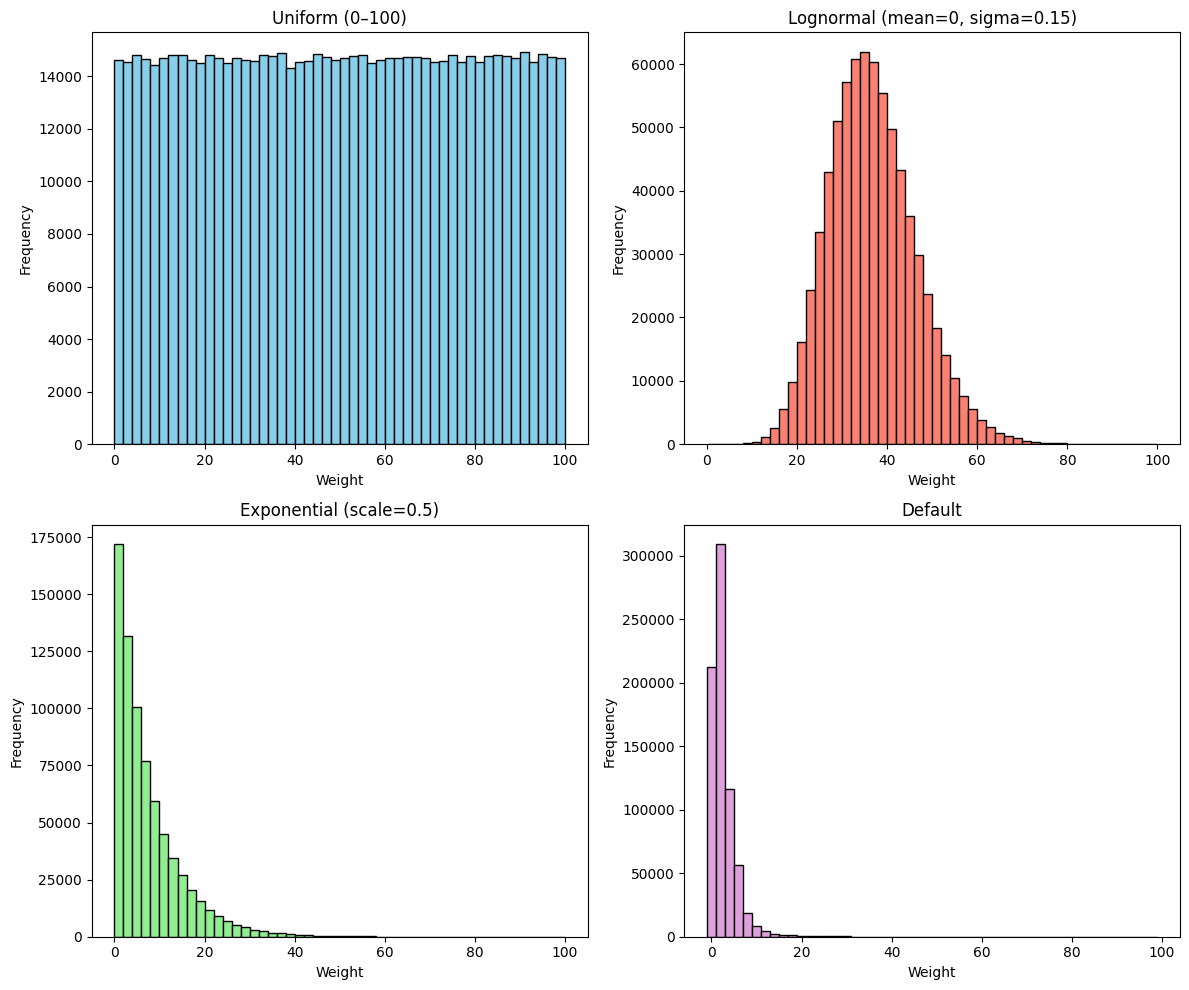

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Uniform
axs[0, 0].hist(new_weights, bins=50, color="skyblue", edgecolor="black")
axs[0, 0].set_title("Uniform (0–100)")

# Lognormal
axs[0, 1].hist(lognorm_weights, bins=50, color="salmon", edgecolor="black")
axs[0, 1].set_title("Lognormal (mean=0, sigma=0.15)")

# Exponential
axs[1, 0].hist(exp_weights, bins=50, color="lightgreen", edgecolor="black")
axs[1, 0].set_title("Exponential (scale=0.5)")

# Poisson
axs[1, 1].hist(default_weights, bins=50, color="plum", edgecolor="black", align="left")
axs[1, 1].set_title("Default")

for ax in axs.flat:
    ax.set_xlabel("Weight")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()